<a href="https://colab.research.google.com/github/AaronNg197/Wildfire-image-classification-/blob/main/Wildfire_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to the zip file in your Google Drive
zip_path = '/content/drive/My Drive/wildfire.zip'

# Define the directory where you want to extract the dataset
extract_path = '/content/wildfire_dataset'

# Create the extraction directory if it doesn't exist
import os
os.makedirs(extract_path, exist_ok=True)

# Extract the contents of the zip file
# The -q flag is for quiet mode (less output)
!unzip -q "{zip_path}" -d "{extract_path}"

print(f"Dataset extracted to: {extract_path}")

Dataset extracted to: /content/wildfire_dataset


In [ ]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None # Increase the limit for large images

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import os # Import os for os.path.join

# Define the target image height and width for resizing
img_height = 128
img_width = 128

# Define the path to the extracted dataset
# Updated path to point to the correct subdirectory
data_dir = '/content/wildfire_dataset/the_wildfire_dataset_2n_version'

# Define image transformations
# We'll resize to the specified img_height and img_width
# And convert to a tensor and normalize
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet mean and std
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets using ImageFolder
image_datasets = {x: torchvision.datasets.ImageFolder(
    os.path.join(data_dir, x),
    data_transforms[x])
    for x in ['train', 'val', 'test']}

# Define the batch size
batch_size = 32

# Create DataLoaders
dataloaders = {x: DataLoader(
    image_datasets[x],
    batch_size=batch_size,
    shuffle=True if x == 'train' else False, # Shuffle only training data
    num_workers=2 # Number of subprocesses to use for data loading
    )
    for x in ['train', 'val', 'test']}

# Get dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Get class names (fire and nofire)
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# You can optionally visualize some data batches to verify
# import matplotlib.pyplot as plt
# import numpy as np

# # Function to show images
# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated

# # Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

Dataset sizes: {'train': 1887, 'val': 402, 'test': 410}
Class names: ['fire', 'nofire']


In [ ]:
!ls /content/wildfire_dataset

the_wildfire_dataset_2n_version


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FireCNN(nn.Module):
    def __init__(self):
        super(FireCNN, self).__init__()
        # First Convolutional Block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third Convolutional Block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        # We'll need to calculate the correct input size for the first linear layer
        # after the convolutional and pooling layers. This depends on the input image size.
        # For 128x128 input and 3 pooling layers with kernel_size=2, stride=2,
        # the spatial dimensions are reduced by a factor of 2^3 = 8.
        # So, after the last pooling, the feature maps will be 128/8 x 128/8 = 16x16.
        # With 128 filters in conv3, the size is 128 * 16 * 16 = 32768
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 1) # Output layer for binary classification

    def forward(self, x):
        # Apply first convolutional and pooling layers with ReLU activation
        x = self.pool1(F.relu(self.conv1(x)))

        # Apply second convolutional and pooling layers with ReLU activation
        x = self.pool2(F.relu(self.conv2(x)))

        # Apply third convolutional and pooling layers with ReLU activation
        x = self.pool3(F.relu(self.conv3(x)))

        # Flatten the output for the fully connected layers
        x = x.view(-1, 128 * 16 * 16) # -1 infers the batch size

        # Apply fully connected layers with ReLU activation for the first FC
        x = F.relu(self.fc1(x))

        # Apply the output layer (no activation here, we'll use BCEWithLogitsLoss)
        x = self.fc2(x)

        return x

# Create an instance of the model
model = FireCNN()

# Print the model architecture
print(model)

FireCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)


In [ ]:
import torch.optim as optim

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
# We'll use the Adam optimizer with a learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
import copy
import matplotlib.pyplot as plt

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device) # Move the model to the selected device

# Number of training epochs
num_epochs = 10 # You can adjust this number

# Keep track of the best model weights
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# Lists to store training and validation metrics for plotting
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# Training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            # Track gradients only in train mode
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward + optimize only in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            # Convert outputs to probabilities and then to predicted class (0 or 1)
            preds = torch.sigmoid(outputs) > 0.5
            running_corrects += torch.sum(preds.float() == labels) # Compare float predictions with float labels

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Store metrics
        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc.item()) # Convert tensor to scalar for plotting
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc.item()) # Convert tensor to scalar for plotting


        # Deep copy the model if it has better accuracy than the best so far
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print() # Print a newline after each epoch

print('Training complete')
print(f'Best validation Acc: {best_acc:.4f}')

# Load best model weights
model.load_state_dict(best_model_wts)

Epoch 0/9
----------
train Loss: 0.6521 Acc: 0.6444
val Loss: 0.5666 Acc: 0.7040

Epoch 1/9
----------
train Loss: 0.5061 Acc: 0.7477
val Loss: 0.4854 Acc: 0.7537

Epoch 2/9
----------
train Loss: 0.4564 Acc: 0.7848
val Loss: 0.5015 Acc: 0.7313

Epoch 3/9
----------
train Loss: 0.3929 Acc: 0.8145
val Loss: 0.4255 Acc: 0.8010

Epoch 4/9
----------
train Loss: 0.3482 Acc: 0.8394
val Loss: 0.4426 Acc: 0.8035

Epoch 5/9
----------
train Loss: 0.3483 Acc: 0.8426
val Loss: 0.4458 Acc: 0.7836

Epoch 6/9
----------
train Loss: 0.2824 Acc: 0.8718
val Loss: 0.4422 Acc: 0.8085

Epoch 7/9
----------
train Loss: 0.2236 Acc: 0.9067
val Loss: 0.4495 Acc: 0.7886

Epoch 8/9
----------
train Loss: 0.1830 Acc: 0.9200
val Loss: 0.4629 Acc: 0.8035

Epoch 9/9
----------
train Loss: 0.1244 Acc: 0.9571
val Loss: 0.6311 Acc: 0.7960

Training complete
Best validation Acc: 0.8085


<All keys matched successfully>

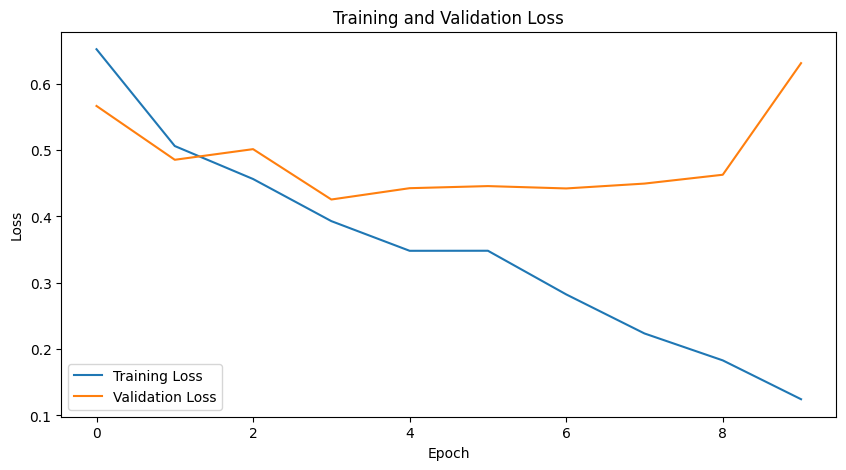

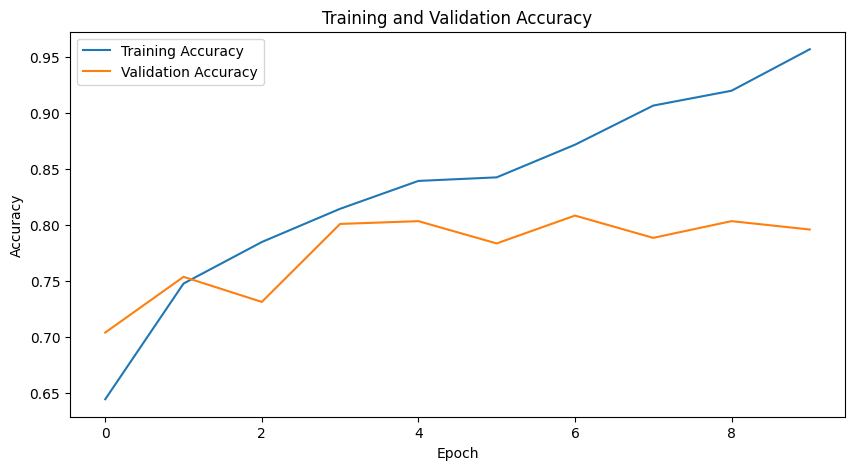

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FireCNN_WithDropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FireCNN_WithDropout, self).__init__()
        # First Convolutional Block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third Convolutional Block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        # Calculate input size after convolutional and pooling layers (same as before)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        # Add Dropout layer after the first fully connected layer
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 1) # Output layer for binary classification

    def forward(self, x):
        # Apply convolutional and pooling layers with ReLU activation
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        # Flatten the output
        x = x.view(-1, 128 * 16 * 16)

        # Apply fully connected layers with ReLU activation and Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Apply dropout
        x = self.fc2(x)

        return x

# Create an instance of the new model with Dropout
model_dropout = FireCNN_WithDropout(dropout_rate=0.5) # You can adjust the dropout rate

# Print the new model architecture
print(model_dropout)

FireCNN_WithDropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)


In [ ]:
import torch.optim as optim

# Define the loss function (same as before)
criterion_dropout = nn.BCEWithLogitsLoss()

# Define the optimizer for the model with Dropout
optimizer_dropout = optim.Adam(model_dropout.parameters(), lr=0.001)

Starting training for model with Dropout for 10 epochs...
--------------------
Epoch 0/9
----------
train Loss: 0.6899 Acc: 0.6047
val Loss: 0.6054 Acc: 0.6443

Epoch 1/9
----------
train Loss: 0.5637 Acc: 0.6773
val Loss: 0.5594 Acc: 0.6891

Epoch 2/9
----------
train Loss: 0.5008 Acc: 0.7340
val Loss: 0.5410 Acc: 0.7239

Epoch 3/9
----------
train Loss: 0.4638 Acc: 0.7790
val Loss: 0.5016 Acc: 0.7289

Epoch 4/9
----------
train Loss: 0.4327 Acc: 0.8055
val Loss: 0.4253 Acc: 0.7811

Epoch 5/9
----------
train Loss: 0.4039 Acc: 0.8166
val Loss: 0.4732 Acc: 0.7687

Epoch 6/9
----------
train Loss: 0.3645 Acc: 0.8347
val Loss: 0.4341 Acc: 0.8035

Epoch 7/9
----------
train Loss: 0.3701 Acc: 0.8304
val Loss: 0.4056 Acc: 0.7985

Epoch 8/9
----------
train Loss: 0.3178 Acc: 0.8691
val Loss: 0.3869 Acc: 0.8184

Epoch 9/9
----------
train Loss: 0.2968 Acc: 0.8771
val Loss: 0.4192 Acc: 0.7761

Training complete for model with Dropout
Best validation Acc (Dropout model): 0.8184


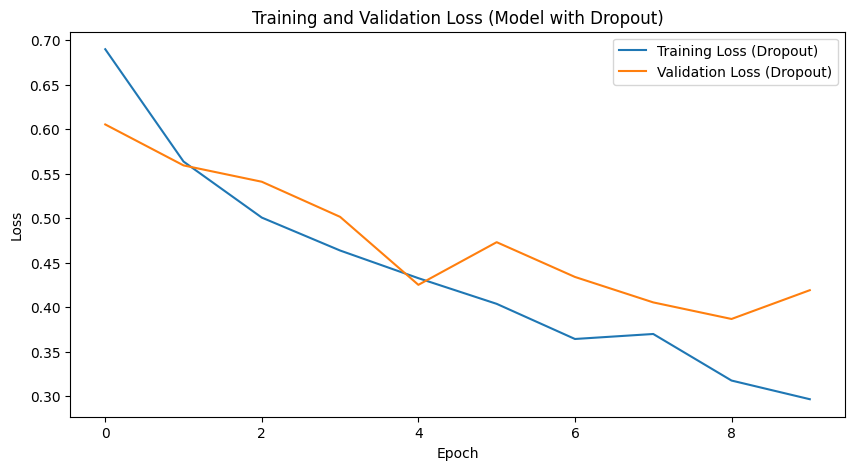

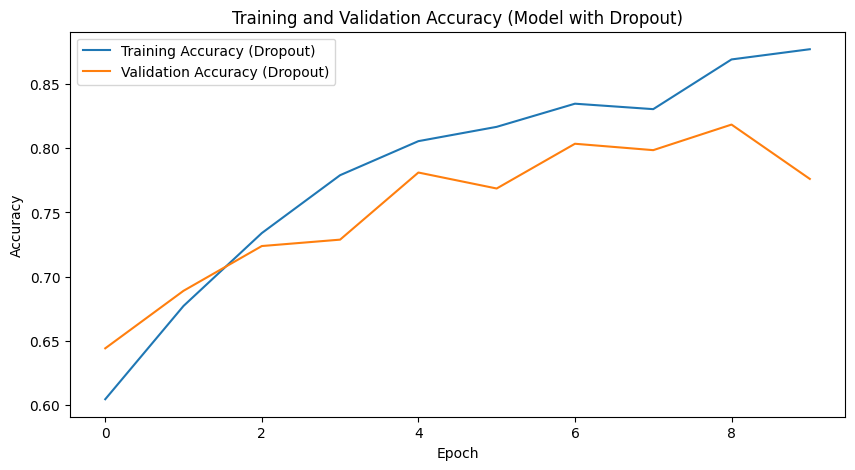

In [ ]:
import time
import copy
import matplotlib.pyplot as plt

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_dropout.to(device) # Move the model with dropout to the selected device

# Number of training epochs (can be the same or adjusted)
num_epochs_dropout = 10

# Keep track of the best model weights for the dropout model
best_model_wts_dropout = copy.deepcopy(model_dropout.state_dict())
best_acc_dropout = 0.0

# Lists to store training and validation metrics for plotting (Dropout model)
train_loss_history_dropout = []
train_acc_history_dropout = []
val_loss_history_dropout = []
val_acc_history_dropout = []

print(f"Starting training for model with Dropout for {num_epochs_dropout} epochs...")
print("-" * 20)

# Training loop for the model with Dropout
for epoch in range(num_epochs_dropout):
    print(f'Epoch {epoch}/{num_epochs_dropout - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model_dropout.train()  # Set model to training mode
        else:
            model_dropout.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

            # Zero the parameter gradients
            optimizer_dropout.zero_grad()

            # Forward pass
            # Track gradients only in train mode
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model_dropout(inputs)
                loss = criterion_dropout(outputs, labels)

                # Backward + optimize only in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer_dropout.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            # Convert outputs to probabilities and then to predicted class (0 or 1)
            preds = torch.sigmoid(outputs) > 0.5
            running_corrects += torch.sum(preds.float() == labels) # Compare float predictions with float labels

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Store metrics
        if phase == 'train':
            train_loss_history_dropout.append(epoch_loss)
            train_acc_history_dropout.append(epoch_acc.item()) # Convert tensor to scalar for plotting
        else:
            val_loss_history_dropout.append(epoch_loss)
            val_acc_history_dropout.append(epoch_acc.item()) # Convert tensor to scalar for plotting

        # Deep copy the model if it has better accuracy than the best so far
        if phase == 'val' and epoch_acc > best_acc_dropout:
            best_acc_dropout = epoch_acc
            best_model_wts_dropout = copy.deepcopy(model_dropout.state_dict())

    print() # Print a newline after each epoch

print('Training complete for model with Dropout')
print(f'Best validation Acc (Dropout model): {best_acc_dropout:.4f}')

# Load best model weights for the dropout model
model_dropout.load_state_dict(best_model_wts_dropout)

# --- Plotting for the Dropout Model ---

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history_dropout, label='Training Loss (Dropout)')
plt.plot(val_loss_history_dropout, label='Validation Loss (Dropout)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Model with Dropout)')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history_dropout, label='Training Accuracy (Dropout)')
plt.plot(val_acc_history_dropout, label='Validation Accuracy (Dropout)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Model with Dropout)')
plt.legend()
plt.show()

**Grid Search - Individual Hyperparameter Combinations**

Below are 9 individual code cells, each representing one combination of Learning Rate (LR) and Dropout Rate.

Please run each cell one by one. After each cell completes, note down the validation accuracy printed in the output.

Once all 9 cells have run, manually compare the validation accuracies to find the best performing combination of LR and Dropout Rate.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Combination 1: LR = 0.01, Dropout Rate = 0.3
lr = 0.01
dropout_rate = 0.3

print(f"Training with LR: {lr}, Dropout Rate: {dropout_rate}")
print("-" * 20)

# Create a new instance of the model with the current dropout rate
model_grid_search_1 = FireCNN_WithDropout(dropout_rate=dropout_rate)
model_grid_search_1.to(device)

# Define a new optimizer with the current learning rate
optimizer_grid_search_1 = optim.Adam(model_grid_search_1.parameters(), lr=lr)

# Define the loss function (same as before)
criterion_grid_search_1 = nn.BCEWithLogitsLoss()

# Number of epochs for this trial
grid_search_epochs = 10

# Training loop for the current combination
best_val_acc_current_trial = 0.0

for epoch in range(grid_search_epochs):
    model_grid_search_1.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        optimizer_grid_search_1.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model_grid_search_1(inputs)
            loss = criterion_grid_search_1(outputs, labels)
            loss.backward()
            optimizer_grid_search_1.step()
        running_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        running_corrects += torch.sum(preds.float() == labels)

    epoch_train_loss = running_loss / dataset_sizes['train']
    epoch_train_acc = running_corrects.double() / dataset_sizes['train']

    # Validation phase for the current trial
    model_grid_search_1.eval()
    running_loss_val = 0.0
    running_corrects_val = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model_grid_search_1(inputs)
            loss = criterion_grid_search_1(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            running_corrects_val += torch.sum(preds.float() == labels)

    epoch_val_loss = running_loss_val / dataset_sizes['val']
    epoch_val_acc = running_corrects_val.double() / dataset_sizes['val']

    print(f'  Epoch {epoch}/{grid_search_epochs - 1} - Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

    # Track best validation accuracy for the current trial
    if epoch_val_acc > best_val_acc_current_trial:
        best_val_acc_current_trial = epoch_val_acc

print("-" * 20)
print(f"Trial Complete - LR: {lr}, Dropout Rate: {dropout_rate}, Best Val Accuracy: {best_val_acc_current_trial:.4f}")

Training with LR: 0.01, Dropout Rate: 0.3
--------------------
  Epoch 0/9 - Train Loss: 6.5999 Acc: 0.5776 | Val Loss: 0.6708 Acc: 0.6119
  Epoch 1/9 - Train Loss: 0.6719 Acc: 0.6131 | Val Loss: 0.6679 Acc: 0.6119
  Epoch 2/9 - Train Loss: 0.6673 Acc: 0.6131 | Val Loss: 0.6679 Acc: 0.6119
  Epoch 3/9 - Train Loss: 0.6690 Acc: 0.6131 | Val Loss: 0.6681 Acc: 0.6119
  Epoch 4/9 - Train Loss: 0.6685 Acc: 0.6131 | Val Loss: 0.6680 Acc: 0.6119
  Epoch 5/9 - Train Loss: 0.6674 Acc: 0.6131 | Val Loss: 0.6680 Acc: 0.6119
  Epoch 6/9 - Train Loss: 0.6693 Acc: 0.6131 | Val Loss: 0.6692 Acc: 0.6119
  Epoch 7/9 - Train Loss: 0.6683 Acc: 0.6131 | Val Loss: 0.6682 Acc: 0.6119
  Epoch 8/9 - Train Loss: 0.6678 Acc: 0.6131 | Val Loss: 0.6680 Acc: 0.6119
  Epoch 9/9 - Train Loss: 0.6687 Acc: 0.6131 | Val Loss: 0.6681 Acc: 0.6119
--------------------
Trial Complete - LR: 0.01, Dropout Rate: 0.3, Best Val Accuracy: 0.6119


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy

# Set device to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Combination 2: LR = 0.01, Dropout Rate = 0.5
lr = 0.01
dropout_rate = 0.5

print(f"Training with LR: {lr}, Dropout Rate: {dropout_rate}")
print("-" * 20)

# Create a new instance of the model with the current dropout rate
model_grid_search_2 = FireCNN_WithDropout(dropout_rate=dropout_rate)
model_grid_search_2.to(device)

# Define a new optimizer with the current learning rate
optimizer_grid_search_2 = optim.Adam(model_grid_search_2.parameters(), lr=lr)

# Define the loss function (same as before)
criterion_grid_search_2 = nn.BCEWithLogitsLoss()

# Number of epochs for this trial
grid_search_epochs = 10

# Training loop for the current combination
best_val_acc_current_trial = 0.0

for epoch in range(grid_search_epochs):
    model_grid_search_2.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        optimizer_grid_search_2.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model_grid_search_2(inputs)
            loss = criterion_grid_search_2(outputs, labels)
            loss.backward()
            optimizer_grid_search_2.step()
        running_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        running_corrects += torch.sum(preds.float() == labels)

    epoch_train_loss = running_loss / dataset_sizes['train']
    epoch_train_acc = running_corrects.double() / dataset_sizes['train']

    # Validation phase for the current trial
    model_grid_search_2.eval()
    running_loss_val = 0.0
    running_corrects_val = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model_grid_search_2(inputs)
            loss = criterion_grid_search_2(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            running_corrects_val += torch.sum(preds.float() == labels)

    epoch_val_loss = running_loss_val / dataset_sizes['val']
    epoch_val_acc = running_corrects_val.double() / dataset_sizes['val']

    print(f'  Epoch {epoch}/{grid_search_epochs - 1} - Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

    # Track best validation accuracy for the current trial
    if epoch_val_acc > best_val_acc_current_trial:
        best_val_acc_current_trial = epoch_val_acc

print("-" * 20)
print(f"Trial Complete - LR: {lr}, Dropout Rate: {dropout_rate}, Best Val Accuracy: {best_val_acc_current_trial:.4f}")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Combination 3: LR = 0.01, Dropout Rate = 0.7
lr = 0.01
dropout_rate = 0.7

print(f"Training with LR: {lr}, Dropout Rate: {dropout_rate}")
print("-" * 20)

# Create a new instance of the model with the current dropout rate
model_grid_search_3 = FireCNN_WithDropout(dropout_rate=dropout_rate)
model_grid_search_3.to(device)

# Define a new optimizer with the current learning rate
optimizer_grid_search_3 = optim.Adam(model_grid_search_3.parameters(), lr=lr)

# Define the loss function (same as before)
criterion_grid_search_3 = nn.BCEWithLogitsLoss()

# Number of epochs for this trial
grid_search_epochs = 10

# Training loop for the current combination
best_val_acc_current_trial = 0.0

for epoch in range(grid_search_epochs):
    model_grid_search_3.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        optimizer_grid_search_3.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model_grid_search_3(inputs)
            loss = criterion_grid_search_3(outputs, labels)
            loss.backward()
            optimizer_grid_search_3.step()
        running_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        running_corrects += torch.sum(preds.float() == labels)

    epoch_train_loss = running_loss / dataset_sizes['train']
    epoch_train_acc = running_corrects.double() / dataset_sizes['train']

    # Validation phase for the current trial
    model_grid_search_3.eval()
    running_loss_val = 0.0
    running_corrects_val = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model_grid_search_3(inputs)
            loss = criterion_grid_search_3(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            running_corrects_val += torch.sum(preds.float() == labels)

    epoch_val_loss = running_loss_val / dataset_sizes['val']
    epoch_val_acc = running_corrects_val.double() / dataset_sizes['val']

    print(f'  Epoch {epoch}/{grid_search_epochs - 1} - Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

    # Track best validation accuracy for the current trial
    if epoch_val_acc > best_val_acc_current_trial:
        best_val_acc_current_trial = epoch_val_acc

print("-" * 20)
print(f"Trial Complete - LR: {lr}, Dropout Rate: {dropout_rate}, Best Val Accuracy: {best_val_acc_current_trial:.4f}")

Training with LR: 0.01, Dropout Rate: 0.7
--------------------


NameError: name 'dataloaders' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Combination 4: LR = 0.001, Dropout Rate = 0.3
lr = 0.001
dropout_rate = 0.3

print(f"Training with LR: {lr}, Dropout Rate: {dropout_rate}")
print("-" * 20)

# Create a new instance of the model with the current dropout rate
model_grid_search_4 = FireCNN_WithDropout(dropout_rate=dropout_rate)
model_grid_search_4.to(device)

# Define a new optimizer with the current learning rate
optimizer_grid_search_4 = optim.Adam(model_grid_search_4.parameters(), lr=lr)

# Define the loss function (same as before)
criterion_grid_search_4 = nn.BCEWithLogitsLoss()

# Number of epochs for this trial
grid_search_epochs = 10

# Training loop for the current combination
best_val_acc_current_trial = 0.0

for epoch in range(grid_search_epochs):
    model_grid_search_4.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        optimizer_grid_search_4.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model_grid_search_4(inputs)
            loss = criterion_grid_search_4(outputs, labels)
            loss.backward()
            optimizer_grid_search_4.step()
        running_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        running_corrects += torch.sum(preds.float() == labels)

    epoch_train_loss = running_loss / dataset_sizes['train']
    epoch_train_acc = running_corrects.double() / dataset_sizes['train']

    # Validation phase for the current trial
    model_grid_search_4.eval()
    running_loss_val = 0.0
    running_corrects_val = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model_grid_search_4(inputs)
            loss = criterion_grid_search_4(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            running_corrects_val += torch.sum(preds.float() == labels)

    epoch_val_loss = running_loss_val / dataset_sizes['val']
    epoch_val_acc = running_corrects_val.double() / dataset_sizes['val']

    print(f'  Epoch {epoch}/{grid_search_epochs - 1} - Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

    # Track best validation accuracy for the current trial
    if epoch_val_acc > best_val_acc_current_trial:
        best_val_acc_current_trial = epoch_val_acc

print("-" * 20)
print(f"Trial Complete - LR: {lr}, Dropout Rate: {dropout_rate}, Best Val Accuracy: {best_val_acc_current_trial:.4f}")

Training with LR: 0.001, Dropout Rate: 0.3
--------------------


NameError: name 'dataloaders' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Combination 5: LR = 0.001, Dropout Rate = 0.5
lr = 0.001
dropout_rate = 0.5

print(f"Training with LR: {lr}, Dropout Rate: {dropout_rate}")
print("-" * 20)

# Create a new instance of the model with the current dropout rate
model_grid_search_5 = FireCNN_WithDropout(dropout_rate=dropout_rate)
model_grid_search_5.to(device)

# Define a new optimizer with the current learning rate
optimizer_grid_search_5 = optim.Adam(model_grid_search_5.parameters(), lr=lr)

# Define the loss function (same as before)
criterion_grid_search_5 = nn.BCEWithLogitsLoss()

# Number of epochs for this trial
grid_search_epochs = 10

# Training loop for the current combination
best_val_acc_current_trial = 0.0

for epoch in range(grid_search_epochs):
    model_grid_search_5.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        optimizer_grid_search_5.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model_grid_search_5(inputs)
            loss = criterion_grid_search_5(outputs, labels)
            loss.backward()
            optimizer_grid_search_5.step()
        running_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        running_corrects += torch.sum(preds.float() == labels)

    epoch_train_loss = running_loss / dataset_sizes['train']
    epoch_train_acc = running_corrects.double() / dataset_sizes['train']

    # Validation phase for the current trial
    model_grid_search_5.eval()
    running_loss_val = 0.0
    running_corrects_val = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model_grid_search_5(inputs)
            loss = criterion_grid_search_5(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            running_corrects_val += torch.sum(preds.float() == labels)

    epoch_val_loss = running_loss_val / dataset_sizes['val']
    epoch_val_acc = running_corrects_val.double() / dataset_sizes['val']

    print(f'  Epoch {epoch}/{grid_search_epochs - 1} - Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

    # Track best validation accuracy for the current trial
    if epoch_val_acc > best_val_acc_current_trial:
        best_val_acc_current_trial = epoch_val_acc

print("-" * 20)
print(f"Trial Complete - LR: {lr}, Dropout Rate: {dropout_rate}, Best Val Accuracy: {best_val_acc_current_trial:.4f}")

Training with LR: 0.001, Dropout Rate: 0.5
--------------------


NameError: name 'dataloaders' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Combination 6: LR = 0.001, Dropout Rate = 0.7
lr = 0.001
dropout_rate = 0.7

print(f"Training with LR: {lr}, Dropout Rate: {dropout_rate}")
print("-" * 20)

# Create a new instance of the model with the current dropout rate
model_grid_search_6 = FireCNN_WithDropout(dropout_rate=dropout_rate)
model_grid_search_6.to(device)

# Define a new optimizer with the current learning rate
optimizer_grid_search_6 = optim.Adam(model_grid_search_6.parameters(), lr=lr)

# Define the loss function (same as before)
criterion_grid_search_6 = nn.BCEWithLogitsLoss()

# Number of epochs for this trial
grid_search_epochs = 10

# Training loop for the current combination
best_val_acc_current_trial = 0.0

for epoch in range(grid_search_epochs):
    model_grid_search_6.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        optimizer_grid_search_6.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model_grid_search_6(inputs)
            loss = criterion_grid_search_6(outputs, labels)
            loss.backward()
            optimizer_grid_search_6.step()
        running_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        running_corrects += torch.sum(preds.float() == labels)

    epoch_train_loss = running_loss / dataset_sizes['train']
    epoch_train_acc = running_corrects.double() / dataset_sizes['train']

    # Validation phase for the current trial
    model_grid_search_6.eval()
    running_loss_val = 0.0
    running_corrects_val = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model_grid_search_6(inputs)
            loss = criterion_grid_search_6(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            running_corrects_val += torch.sum(preds.float() == labels)

    epoch_val_loss = running_loss_val / dataset_sizes['val']
    epoch_val_acc = running_corrects_val.double() / dataset_sizes['val']

    print(f'  Epoch {epoch}/{grid_search_epochs - 1} - Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

    # Track best validation accuracy for the current trial
    if epoch_val_acc > best_val_acc_current_trial:
        best_val_acc_current_trial = epoch_val_acc

print("-" * 20)
print(f"Trial Complete - LR: {lr}, Dropout Rate: {dropout_rate}, Best Val Accuracy: {best_val_acc_current_trial:.4f}")

Training with LR: 0.001, Dropout Rate: 0.7
--------------------


NameError: name 'dataloaders' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Combination 7: LR = 0.0001, Dropout Rate = 0.3
lr = 0.0001
dropout_rate = 0.3

print(f"Training with LR: {lr}, Dropout Rate: {dropout_rate}")
print("-" * 20)

# Create a new instance of the model with the current dropout rate
model_grid_search_7 = FireCNN_WithDropout(dropout_rate=dropout_rate)
model_grid_search_7.to(device)

# Define a new optimizer with the current learning rate
optimizer_grid_search_7 = optim.Adam(model_grid_search_7.parameters(), lr=lr)

# Define the loss function (same as before)
criterion_grid_search_7 = nn.BCEWithLogitsLoss()

# Number of epochs for this trial
grid_search_epochs = 10

# Training loop for the current combination
best_val_acc_current_trial = 0.0

for epoch in range(grid_search_epochs):
    model_grid_search_7.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        optimizer_grid_search_7.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model_grid_search_7(inputs)
            loss = criterion_grid_search_7(outputs, labels)
            loss.backward()
            optimizer_grid_search_7.step()
        running_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        running_corrects += torch.sum(preds.float() == labels)

    epoch_train_loss = running_loss / dataset_sizes['train']
    epoch_train_acc = running_corrects.double() / dataset_sizes['train']

    # Validation phase for the current trial
    model_grid_search_7.eval()
    running_loss_val = 0.0
    running_corrects_val = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model_grid_search_7(inputs)
            loss = criterion_grid_search_7(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            running_corrects_val += torch.sum(preds.float() == labels)

    epoch_val_loss = running_loss_val / dataset_sizes['val']
    epoch_val_acc = running_corrects_val.double() / dataset_sizes['val']

    print(f'  Epoch {epoch}/{grid_search_epochs - 1} - Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

    # Track best validation accuracy for the current trial
    if epoch_val_acc > best_val_acc_current_trial:
        best_val_acc_current_trial = epoch_val_acc

print("-" * 20)
print(f"Trial Complete - LR: {lr}, Dropout Rate: {dropout_rate}, Best Val Accuracy: {best_val_acc_current_trial:.4f}")

Training with LR: 0.0001, Dropout Rate: 0.3
--------------------


NameError: name 'dataloaders' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Combination 8: LR = 0.0001, Dropout Rate = 0.5
lr = 0.0001
dropout_rate = 0.5

print(f"Training with LR: {lr}, Dropout Rate: {dropout_rate}")
print("-" * 20)

# Create a new instance of the model with the current dropout rate
model_grid_search_8 = FireCNN_WithDropout(dropout_rate=dropout_rate)
model_grid_search_8.to(device)

# Define a new optimizer with the current learning rate
optimizer_grid_search_8 = optim.Adam(model_grid_search_8.parameters(), lr=lr)

# Define the loss function (same as before)
criterion_grid_search_8 = nn.BCEWithLogitsLoss()

# Number of epochs for this trial
grid_search_epochs = 10

# Training loop for the current combination
best_val_acc_current_trial = 0.0

for epoch in range(grid_search_epochs):
    model_grid_search_8.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        optimizer_grid_search_8.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model_grid_search_8(inputs)
            loss = criterion_grid_search_8(outputs, labels)
            loss.backward()
            optimizer_grid_search_8.step()
        running_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        running_corrects += torch.sum(preds.float() == labels)

    epoch_train_loss = running_loss / dataset_sizes['train']
    epoch_train_acc = running_corrects.double() / dataset_sizes['train']

    # Validation phase for the current trial
    model_grid_search_8.eval()
    running_loss_val = 0.0
    running_corrects_val = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model_grid_search_8(inputs)
            loss = criterion_grid_search_8(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            running_corrects_val += torch.sum(preds.float() == labels)

    epoch_val_loss = running_loss_val / dataset_sizes['val']
    epoch_val_acc = running_corrects_val.double() / dataset_sizes['val']

    print(f'  Epoch {epoch}/{grid_search_epochs - 1} - Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

    # Track best validation accuracy for the current trial
    if epoch_val_acc > best_val_acc_current_trial:
        best_val_acc_current_trial = epoch_val_acc

print("-" * 20)
print(f"Trial Complete - LR: {lr}, Dropout Rate: {dropout_rate}, Best Val Accuracy: {best_val_acc_current_trial:.4f}")

Training with LR: 0.0001, Dropout Rate: 0.5
--------------------


NameError: name 'dataloaders' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Combination 9: LR = 0.0001, Dropout Rate = 0.7
lr = 0.0001
dropout_rate = 0.7

print(f"Training with LR: {lr}, Dropout Rate: {dropout_rate}")
print("-" * 20)

# Create a new instance of the model with the current dropout rate
model_grid_search_9 = FireCNN_WithDropout(dropout_rate=dropout_rate)
model_grid_search_9.to(device)

# Define a new optimizer with the current learning rate
optimizer_grid_search_9 = optim.Adam(model_grid_search_9.parameters(), lr=lr)

# Define the loss function (same as before)
criterion_grid_search_9 = nn.BCEWithLogitsLoss()

# Number of epochs for this trial
grid_search_epochs = 10

# Training loop for the current combination
best_val_acc_current_trial = 0.0

for epoch in range(grid_search_epochs):
    model_grid_search_9.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        optimizer_grid_search_9.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model_grid_search_9(inputs)
            loss = criterion_grid_search_9(outputs, labels)
            loss.backward()
            optimizer_grid_search_9.step()
        running_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        running_corrects += torch.sum(preds.float() == labels)

    epoch_train_loss = running_loss / dataset_sizes['train']
    epoch_train_acc = running_corrects.double() / dataset_sizes['train']

    # Validation phase for the current trial
    model_grid_search_9.eval()
    running_loss_val = 0.0
    running_corrects_val = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model_grid_search_9(inputs)
            loss = criterion_grid_search_9(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            running_corrects_val += torch.sum(preds.float() == labels)

    epoch_val_loss = running_loss_val / dataset_sizes['val']
    epoch_val_acc = running_corrects_val.double() / dataset_sizes['val']

    print(f'  Epoch {epoch}/{grid_search_epochs - 1} - Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

    # Track best validation accuracy for the current trial
    if epoch_val_acc > best_val_acc_current_trial:
        best_val_acc_current_trial = epoch_val_acc

print("-" * 20)
print(f"Trial Complete - LR: {lr}, Dropout Rate: {dropout_rate}, Best Val Accuracy: {best_val_acc_current_trial:.4f}")

Training with LR: 0.0001, Dropout Rate: 0.7
--------------------


NameError: name 'dataloaders' is not defined